In [5]:
%pip install pandas
%pip install numpy
%pip install scipy
%pip install matplotlib
%pip install seaborn
%pip install requests
%pip install tqdm
%pip install scikit-learn

Loading bike sharing data...
Fetching data from URL...
Reading data into DataFrame...
Successfully loaded data with shape: (17379, 17)

Performing feature engineering...
✓ Feature engineering completed

Preparing data...

Training set size: (10427, 17)
Test set size: (6952, 17)

Training Gaussian Process Regression...

Computing kernel matrix...


Computing Kernel:   0%|          | 0/6 [00:00<?, ?it/s]


Computing Cholesky decomposition...

Solving linear system...

Evaluating model...


Making predictions:   0%|          | 0/7 [00:00<?, ?it/s]

Computing Kernel:   0%|          | 0/1 [00:00<?, ?it/s]

Computing Kernel:   0%|          | 0/1 [00:00<?, ?it/s]

Computing Kernel:   0%|          | 0/1 [00:00<?, ?it/s]

Computing Kernel:   0%|          | 0/1 [00:00<?, ?it/s]

Computing Kernel:   0%|          | 0/1 [00:00<?, ?it/s]

Computing Kernel:   0%|          | 0/1 [00:00<?, ?it/s]

Computing Kernel:   0%|          | 0/1 [00:00<?, ?it/s]

Computing Kernel:   0%|          | 0/1 [00:00<?, ?it/s]

Computing Kernel:   0%|          | 0/1 [00:00<?, ?it/s]

Computing Kernel:   0%|          | 0/1 [00:00<?, ?it/s]

Computing Kernel:   0%|          | 0/1 [00:00<?, ?it/s]

Computing Kernel:   0%|          | 0/1 [00:00<?, ?it/s]

Computing Kernel:   0%|          | 0/1 [00:00<?, ?it/s]

Computing Kernel:   0%|          | 0/1 [00:00<?, ?it/s]

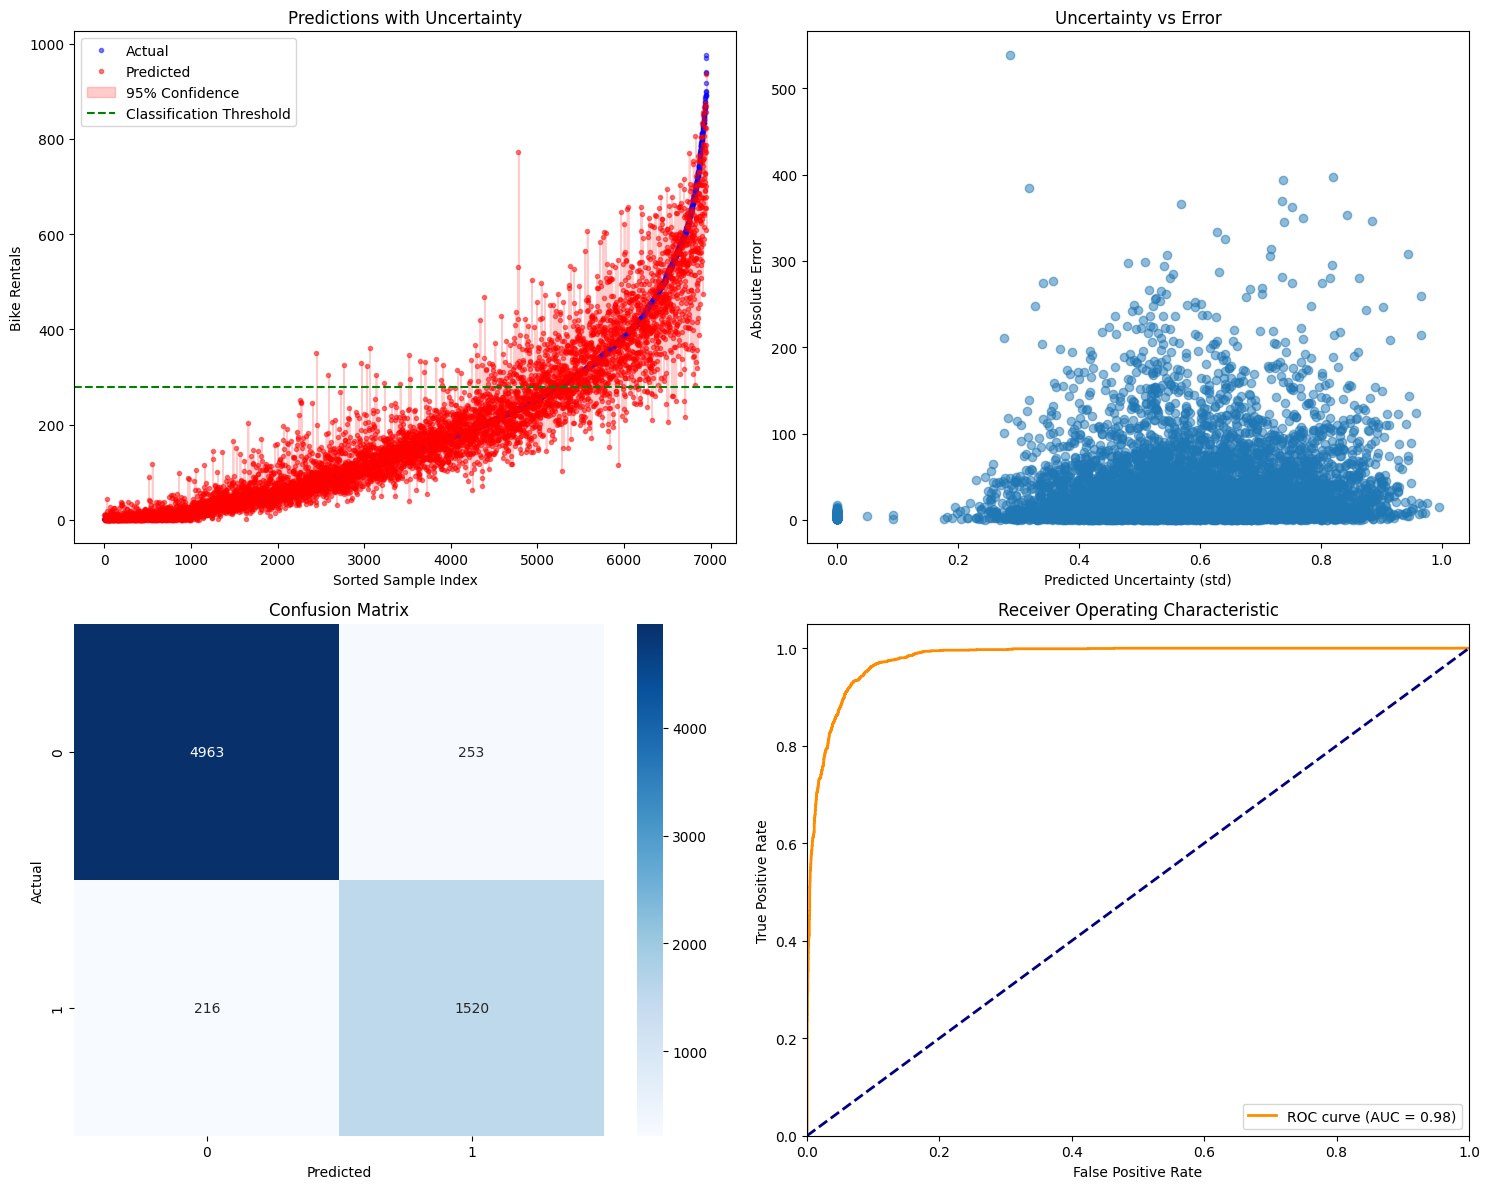


Regression Metrics:
--------------------------------------------------
RMSE: 57.72
MAE: 35.08
R²: 0.90
NMSE: 0.10
MAPE: 40.94%

Uncertainty Metrics:
--------------------------------------------------
Mean Uncertainty: 0.57
Uncertainty Coverage: 0.05
Calibration Score: 0.05

Classification Metrics:
--------------------------------------------------
Classification Threshold: 278.00
Accuracy: 0.93
Precision: 0.86
Recall: 0.88
F1-Score: 0.87
ROC-AUC: 0.98
Specificity: 0.95

Confusion Matrix Components:
--------------------------------------------------
True Positives: 1520
True Negatives: 4963
False Positives: 253
False Negatives: 216


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_score, recall_score, accuracy_score,mean_squared_error,
                             mean_absolute_error, r2_score,f1_score,
                             roc_auc_score, confusion_matrix)
import scipy
import scipy.stats
from scipy import stats
import warnings
from scipy.spatial.distance import cdist
from scipy.special import gamma, kv
from typing import Tuple, Dict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import requests
from io import StringIO
from sklearn.metrics import roc_curve, auc
import seaborn as sns
warnings.filterwarnings('ignore')

# Feature Engineering
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    """
    Perform feature engineering on the dataset.
    """
    data['dteday'] = pd.to_datetime(data['dteday'])
    data['hour'] = data['hr']
    data['day'] = data['dteday'].dt.day
    data['month'] = data['dteday'].dt.month
    data['year'] = data['dteday'].dt.year.map({2011: 0, 2012: 1})
    data['weekday'] = data['dteday'].dt.weekday
    data['peak_hour'] = (((data['hour'].between(7, 9)) |
                         (data['hour'].between(16, 19)))).astype(int)
    data['is_weekend'] = (data['weekday'] >= 5).astype(int)
    data['weather_severity'] = data['weathersit'].map(
        {1: 'Good', 2: 'Moderate', 3: 'Bad', 4: 'Very Bad'})

    for col, max_val in [('hour', 24), ('month', 12)]:
        data[f'{col}_sin'] = np.sin(2 * np.pi * data[col] / max_val)
        data[f'{col}_cos'] = np.cos(2 * np.pi * data[col] / max_val)

    print("✓ Feature engineering completed")
    return data

# Data Preparation
def prepare_data(data: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    """
    Prepare feature matrix X and target vector y.
    """
    numerical_features = ['temp', 'atemp', 'hum', 'windspeed',
                         'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    categorical_features = ['season', 'year', 'holiday', 'workingday',
                          'weather_severity', 'peak_hour', 'is_weekend']

    X = pd.concat([
        pd.get_dummies(data[categorical_features], drop_first=True),
        pd.DataFrame(StandardScaler().fit_transform(data[numerical_features]),
                    columns=numerical_features)
    ], axis=1)

    y = data['cnt'].values
    X = X.fillna(X.mean()).values.astype(np.float64)
    y = y.astype(np.float64)
    return X, y

def matern_kernel(X1: np.ndarray,
                X2: np.ndarray,
                length_scale: float = 1.0,
                nu: float = 2.5,
                sigma: float = 1.0,
                noise: float = 1e-8,
                batch_size: int = 1000) -> np.ndarray:
    """
    Compute Matern kernel with batching and clipped noise.
    """
    if nu <= 0 or sigma <= 0 or length_scale <= 0:
        raise ValueError("Parameters must be positive")

    X1, X2 = np.asarray(X1), np.asarray(X2)
    n1, n2 = X1.shape[0], X2.shape[0]
    K = np.zeros((n1, n2))

    for i in tqdm(range(0, n1, batch_size), desc="Computing Kernel"):
        batch_end = min(i + batch_size, n1)
        X1_batch = X1[i:batch_end]

        for j in range(0, n2, batch_size):
            j_end = min(j + batch_size, n2)
            X2_batch = X2[j:j_end]

            distances = cdist(X1_batch, X2_batch, metric='euclidean') / length_scale
            distances = np.maximum(distances, 1e-10)

            sqrt_2nu = np.sqrt(2 * nu)
            scaled_distances = sqrt_2nu * distances

            factor = sigma**2 * (2**(1-nu)) / gamma(nu)
            K_batch = factor * (scaled_distances**nu) * kv(nu, scaled_distances)

            mask = np.isnan(K_batch) | np.isinf(K_batch)
            K_batch[mask] = sigma**2

            K[i:batch_end, j:j_end] = K_batch

    if X1.shape == X2.shape and np.array_equal(X1, X2):
        K += noise * np.eye(n1)

    return K

def fit_gpr(X: np.ndarray,
          y: np.ndarray,
          length_scale: float = 1.0,
          nu: float = 2.5,
          sigma: float = 1.0,
          noise: float = 1e-8,
          batch_size: int = 1000) -> Dict:
    """
    Fit GPR model with clipped noise.
    """
    print("\nComputing kernel matrix...")
    K = matern_kernel(X, X, length_scale, nu, sigma, noise, batch_size)

    print("\nComputing Cholesky decomposition...")
    try:
        L = np.linalg.cholesky(K)
    except np.linalg.LinAlgError:
        print("Warning: Adding jitter to ensure positive definiteness")
        K += 1e-10 * np.eye(K.shape[0])
        L = np.linalg.cholesky(K)

    print("\nSolving linear system...")
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))

    return {
        'X_train': X,
        'y_train': y,
        'alpha': alpha,
        'L': L,
        'length_scale': length_scale,
        'nu': nu,
        'sigma': sigma,
        'noise': noise
    }

def predict_gpr(X_new: np.ndarray,
               model: Dict,
               batch_size: int = 1000,
               min_value: float = 0.0) -> Tuple[np.ndarray, np.ndarray]:
    """
    Make predictions with clipped uncertainty estimates.
    """
    n_test = X_new.shape[0]
    means = np.zeros(n_test)
    vars = np.zeros(n_test)

    for i in tqdm(range(0, n_test, batch_size), desc="Making predictions"):
        batch_end = min(i + batch_size, n_test)
        X_batch = X_new[i:batch_end]

        K_star = matern_kernel(X_batch, model['X_train'],
                            model['length_scale'],
                            model['nu'],
                            model['sigma'],
                            batch_size=batch_size)

        means[i:batch_end] = K_star @ model['alpha']

        v = np.linalg.solve(model['L'], K_star.T)
        K_star_star = matern_kernel(X_batch, X_batch,
                                 model['length_scale'],
                                 model['nu'],
                                 model['sigma'],
                                 batch_size=batch_size)
        vars[i:batch_end] = np.diag(K_star_star - v.T @ v)

    # Clip predictions and adjust uncertainties
    means = np.maximum(means, min_value)
    close_to_min = means < (min_value + 2 * np.sqrt(vars))
    vars[close_to_min] *= (means[close_to_min] - min_value) / (2 * np.sqrt(vars[close_to_min]))

    return means, np.sqrt(vars)

def load_bike_sharing_data() -> pd.DataFrame:
    """
    Load bike sharing data from GitHub URL.
    """
    url = "https://raw.githubusercontent.com/mehulbafnaa/BIKE_RENTAL_DEMAND/refs/heads/main/UCI_bike_sharing.csv"

    try:
        print("Fetching data from URL...")
        response = requests.get(url)
        response.raise_for_status()

        print("Reading data into DataFrame...")
        data = pd.read_csv(StringIO(response.text))
        print(f"Successfully loaded data with shape: {data.shape}")
        return data

    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def evaluate_gpr(name: str,
                model: Dict,
                X_test: np.ndarray,
                y_test: np.ndarray,
                threshold_percentile: float = 75) -> Dict[str, float]:
    """Enhanced evaluation with additional metrics including classification metrics."""
    y_pred, y_std = predict_gpr(X_test, model)

    # Standard regression metrics
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R²': r2_score(y_test, y_pred),
        'Mean Uncertainty': np.mean(y_std),
        'Uncertainty Coverage': np.mean(np.abs(y_test - y_pred) <= 2 * y_std),
        'NMSE': mean_squared_error(y_test, y_pred) / np.var(y_test),
        'MAPE': np.mean(np.abs((y_test - y_pred) / y_test)) * 100,
        'Calibration Score': compute_calibration_score(y_test, y_pred, y_std)
    }

    # Convert regression to classification using threshold
    threshold = np.percentile(y_test, threshold_percentile)
    y_test_binary = (y_test > threshold).astype(int)
    y_pred_binary = (y_pred > threshold).astype(int)

    # Calculate classification metrics
    classification_metrics = compute_classification_metrics(
        y_test_binary, y_pred_binary, y_pred, threshold)
    metrics.update(classification_metrics)

    # Create figure with 2x2 subplots
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Predictions vs Actual with uncertainty (top-left)
    ax = axes[0, 0]
    idx = np.argsort(y_test)
    ax.plot(y_test[idx], 'b.', label='Actual', alpha=0.5)
    ax.plot(y_pred[idx], 'r.', label='Predicted', alpha=0.5)
    ax.fill_between(range(len(idx)),
                   y_pred[idx] - 2*y_std[idx],
                   y_pred[idx] + 2*y_std[idx],
                   alpha=0.2, color='r',
                   label='95% Confidence')
    ax.axhline(y=threshold, color='g', linestyle='--', label='Classification Threshold')
    ax.set_title('Predictions with Uncertainty')
    ax.set_xlabel('Sorted Sample Index')
    ax.set_ylabel('Bike Rentals')
    ax.legend()

    # 2. Uncertainty vs Error (top-right)
    ax = axes[0, 1]
    ax.scatter(y_std, np.abs(y_test - y_pred), alpha=0.5)
    ax.set_xlabel('Predicted Uncertainty (std)')
    ax.set_ylabel('Absolute Error')
    ax.set_title('Uncertainty vs Error')

    # 3. Confusion Matrix (bottom-left)
    ax = axes[1, 0]
    plot_confusion_matrix(y_test_binary, y_pred_binary, ax)

    # 4. ROC Curve (bottom-right)
    ax = axes[1, 1]
    plot_roc_curve(y_test_binary, y_pred, ax)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    return metrics

def compute_calibration_score(y_true: np.ndarray,
                           y_pred: np.ndarray,
                           y_std: np.ndarray,
                           n_bins: int = 10) -> float:
    """
    Compute calibration score using binned predictions.
    """
    z_scores = (y_true - y_pred) / y_std
    proportions = []
    expected = []

    for p in np.linspace(0, 100, n_bins):
        threshold = scipy.stats.norm.ppf(p/100)
        proportions.append(np.mean(z_scores <= threshold))
        expected.append(p/100)

    return np.mean((np.array(proportions) - np.array(expected))**2)


def compute_classification_metrics(y_true_binary: np.ndarray,
                                y_pred_binary: np.ndarray,
                                y_pred_prob: np.ndarray,
                                threshold: float) -> Dict[str, float]:
    """
    Compute classification metrics for regression results.
    """

    metrics = {
        'Accuracy': accuracy_score(y_true_binary, y_pred_binary),
        'Precision': precision_score(y_true_binary, y_pred_binary),
        'Recall': recall_score(y_true_binary, y_pred_binary),
        'F1-Score': f1_score(y_true_binary, y_pred_binary),
        'ROC-AUC': roc_auc_score(y_true_binary, y_pred_prob),
        'Classification Threshold': threshold
    }

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()
    metrics.update({
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn,
        'True Positives': tp,
        'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0
    })

    return metrics

def plot_confusion_matrix(y_true: np.ndarray,
                        y_pred: np.ndarray,
                        ax: plt.Axes):
    """
    Plot confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')

def plot_roc_curve(y_true: np.ndarray,
                  y_pred_prob: np.ndarray,
                  ax: plt.Axes):
    """
    Plot ROC curve.
    """

    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color='darkorange', lw=2,
            label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    ax.legend(loc="lower right")


def main():
    print("Loading bike sharing data...")
    data = load_bike_sharing_data()

    print("\nPerforming feature engineering...")
    data = feature_engineering(data)

    print("\nPreparing data...")
    X, y = prepare_data(data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    print(f"\nTraining set size: {X_train.shape}")
    print(f"Test set size: {X_test.shape}")

    print("\nTraining Gaussian Process Regression...")
    gpr_model = fit_gpr(X_train, y_train,
                      length_scale=1.0,
                      nu=1.5,
                      sigma=1.0,
                      noise=0.1,
                      batch_size=2000)

    print("\nEvaluating model...")
    results = evaluate_gpr("Gaussian Process", gpr_model, X_test, y_test)

    # Display all metrics organized by category
    print("\nRegression Metrics:")
    print("-" * 50)
    print(f"RMSE: {results['RMSE']:.2f}")
    print(f"MAE: {results['MAE']:.2f}")
    print(f"R²: {results['R²']:.2f}")
    print(f"NMSE: {results['NMSE']:.2f}")
    print(f"MAPE: {results['MAPE']:.2f}%")

    print("\nUncertainty Metrics:")
    print("-" * 50)
    print(f"Mean Uncertainty: {results['Mean Uncertainty']:.2f}")
    print(f"Uncertainty Coverage: {results['Uncertainty Coverage']:.2f}")
    print(f"Calibration Score: {results['Calibration Score']:.2f}")

    print("\nClassification Metrics:")
    print("-" * 50)
    print(f"Classification Threshold: {results['Classification Threshold']:.2f}")
    print(f"Accuracy: {results['Accuracy']:.2f}")
    print(f"Precision: {results['Precision']:.2f}")
    print(f"Recall: {results['Recall']:.2f}")
    print(f"F1-Score: {results['F1-Score']:.2f}")
    print(f"ROC-AUC: {results['ROC-AUC']:.2f}")
    print(f"Specificity: {results['Specificity']:.2f}")

    print("\nConfusion Matrix Components:")
    print("-" * 50)
    print(f"True Positives: {results['True Positives']}")
    print(f"True Negatives: {results['True Negatives']}")
    print(f"False Positives: {results['False Positives']}")
    print(f"False Negatives: {results['False Negatives']}")

if __name__ == "__main__":
    main()


